In [1]:
import numpy as np
import h5py
import scipy
import pickle
import matplotlib.pyplot as plt

import Utilities.prelude

In [2]:
folder = 'sedov'
snap = '100'
gamma = 5/3
mach_min = 1.3

In [3]:
# Import data
X = np.load(f'{folder}/{snap}/CMx_{snap}.npy')
Y = np.load(f'{folder}/{snap}/CMy_{snap}.npy')
Z = np.load(f'{folder}/{snap}/CMz_{snap}.npy')
P = np.load(f'{folder}/{snap}/P_{snap}.npy')
T = np.load(f'{folder}/{snap}/T_{snap}.npy')
Den = np.load(f'{folder}/{snap}/Den_{snap}.npy')
if folder == 'TDE':
    Star = np.load(f'{folder}/{snap}/Star_{snap}.npy')
Elad_divV = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
Eladx_rho = np.load(f'{folder}/{snap}/DrhoDx_{snap}.npy')
Elady_rho = np.load(f'{folder}/{snap}/DrhoDy_{snap}.npy')
Eladz_rho = np.load(f'{folder}/{snap}/DrhoDz_{snap}.npy')
Eladx_p = np.load(f'{folder}/{snap}/DpDx_{snap}.npy')
Elady_p = np.load(f'{folder}/{snap}/DpDy_{snap}.npy')
Eladz_p = np.load(f'{folder}/{snap}/DpDz_{snap}.npy')

In [4]:
# Making data ready to be used
if all(T) == 0:
    print('all T=0, bro. Compute by myself!')
    T = P/Den
if folder == 'TDE':
    Star = np.load(f'{folder}/{snap}/Star_{snap}.npy')
    Den[Star<0.999] = 0
coordinates = np.array([X,Y,Z]).T

all T=0, bro. Compute by myself!


In [5]:
# Re-build Voronoi
def voronoi_neigh(coordinates):
    vor = scipy.spatial.Voronoi(coordinates)
    num_centers = vor.points.shape[0]
    connections = vor.ridge_points  
    graph = {}
    for center_index in np.arange(num_centers):
        # A -> B
        interesting_connections_first = connections[connections[:,0]==center_index]
        neighbours_list_first = interesting_connections_first[:,1]
        # B -> A
        interesting_connections_second = connections[connections[:,1]==center_index]
        neighbours_list_second = interesting_connections_second[:,0]
        # unique neighbours list
        neighbours_list = np.concatenate([neighbours_list_first, neighbours_list_second])
        neighbours_list = np.unique(neighbours_list)
        # compute the distance vectors
        # second_points_vector = coordinates[neighbours_list]
        # distance_vectors_list = second_points_vector - coordinates[center_index]
        # collecting the features
        graph[center_index] = {"neighbours_indeces": neighbours_list}#, "distance_vectors_list": distance_vectors_list}
            
    return graph

def walkTheGraph(coordinates, graph, current_position, suggested_movement, direction):
    # find all the neighbours
    # distance_vectors_list = graph[current_position]['distance_vectors_list']
    neighbours_indeces = graph[current_position]['neighbours_indeces']
    neighbours_positions = np.array(coordinates[neighbours_indeces])
    distance_vectors_list = neighbours_positions - coordinates[current_position]

    suggested_movement = np.array([suggested_movement])
    if direction == 'post':
        suggested_movement = - suggested_movement
    # computation
    cosines_sim_list = np.squeeze(distance_vectors_list @ suggested_movement.T) / (np.linalg.norm(distance_vectors_list, axis=-1) * np.linalg.norm(suggested_movement))
    cosines_sim_list = 1 - cosines_sim_list
    chosen_neighbour = graph[current_position]['neighbours_indeces'][np.argmin(cosines_sim_list)]
    return chosen_neighbour

In [6]:
# current_position = 3
# suggested_movement = [0.04531022,  0.2148767]
# graph = voronoi_neigh(coordinates)
# next = walkTheGraph(graph, current_position, suggested_movement)
# all_neigh_indeces = graph[current_position]['neighbours_indeces']
# all_neigh = np.array(coordinates[all_neigh_indeces]).T

# plt.figure()
# plt.scatter(coordinates[current_position][0], coordinates[current_position][1], c = 'k')
# plt.quiver(coordinates[current_position][0], coordinates[current_position][1], suggested_movement[0], suggested_movement[1])
# plt.scatter(all_neigh[0], all_neigh[1], c = 'b')
# plt.scatter(coordinates[next][0], coordinates[next][1], c = 'r', marker = 'x')

In [7]:
def temperature_bump(mach, gamma):
    """ T_post/ T_pre shock according to RH conditions."""
    Tbump =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2)
    return Tbump

def pressure_bump(mach, gamma):
    """ P_post/ P_pre shock according to RH conditions."""
    Pbump = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1)
    return Pbump

def shock_direction(grad):
    """ Find shock direction according eq.(5) by Schaal14 in the point of coordinates indices idx.
    Parameters
    -----------
    grad: array.
        Gradient of temperature(vector of 3 components).
    Returns
    -----------
    ds: array.
        Shock direction (vector of 3 components).
    """
    magnitude = np.linalg.norm(grad, axis=1, keepdims=True)
    small_magnitude_indices = magnitude < 1e-3
    # For small magnitudes, set ds to zero
    ds = np.where(small_magnitude_indices, np.zeros_like(grad), -grad / magnitude)

    return ds

def condition3(coordinates, graph, Press, Temp, current_position, initial_ds, mach_min, gamma):
    """ Last condition fot shock zone by Schaal14 .
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Press, Temp: arrays.
            Coordinates, pressure and temperature of the points of the tree.
    point: array.
            Starting point.
    ds: array (1x3)
        Shock direction.
    mach_min, gamma: floats.
                    Minimum mach number, adiabatic index.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    bool.
        If condition is satisfied or not.
    """
    # Find (the index in the tree of) the point in the pre/post shock region.
    idxpost = walkTheGraph(coordinates, graph, current_position, initial_ds, direction = 'post')
    idxpre = walkTheGraph(coordinates, graph, current_position, initial_ds, direction = 'pre')

    # Store data from the tree
    Tpost = Temp[idxpost]
    Ppost = Press[idxpost]
    Tpre = Temp[idxpre]
    Ppre = Press[idxpre]

    # Last condition fot shock zone by Schaal14
    delta_logT = np.log(Tpost) - np.log(Tpre)
    Tjump = temperature_bump(mach_min, gamma)
    Tjump = np.log(Tjump)
    ratioT = delta_logT / Tjump 
    delta_logP = np.log(Ppost)-np.log(Ppre)
    Pjump = pressure_bump(mach_min, gamma)
    Pjump = np.log(Pjump)
    ratioP = delta_logP / Pjump 
    
    if np.logical_and(ratioT >= 1, ratioP >= 1): 
        return True
    else:
        return False
    
def shock_zone(divv, gradT, gradrho, cond3, check_cond = '3'):
    """ Find the shock zone according conditions in Sec. 2.3.2 of Schaal14. 
    In order to test the code, with "check_con" you can decide if checking all or some of the conditions."""
    if check_cond == '1' or check_cond == '2':
        cond3 = True # so you don't check it
        if check_cond == '2':
            cond2 = np.dot(gradT, gradrho)
        else:
            cond2 = 10
    else:
        cond2 = np.dot(gradT, gradrho)

    if np.logical_and(divv<0, np.logical_and(cond2 > 0, cond3 == True)):
        return True
    else:
        return False

In [8]:
# Mach number from jump considtions
def find_Tmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    a = 2*gamma*(gamma-1)
    minusb = gamma*2 - 6*gamma + ratio*(gamma+1)**2 + 1
    msquared = (minusb + np.sqrt(minusb**2 + 8*a*(gamma-1))) / (2*a)
    return np.sqrt(msquared)

def find_Pmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    msquared = (ratio * (gamma+1) + gamma - 1) / (2*gamma)
    return np.sqrt(msquared)

def find_Denmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    denom = gamma + 1 - ratio * (gamma-1)
    msquared = 2 * ratio / denom
    return np.sqrt(msquared)

Shock surface 

In [9]:
def ray_tracer(coordinates, graph, div_v, ds, are_u_shock, initial_position, direction):
    """ Start from one cell and walk along the shock direction till you go out the shock zone accoridng to Schaal14 (par 2.3.3).
    Parameters
    -----------
    graph: tree.
        Simualation points. 
    div_v: array.
        Velocity divergence of the simulation points.
    ds: 3D-array.
        Shock direction of the simulation points.
    are_u_shock: bool array.
        Says if a simulation cell is in the shock zone.
    initial_position: int.
        (Graph) index of the chosen point.
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns:
    -----------
    outer_neigh: int.
        Graph index of the pre/post shock cell corresponding to the starting one.
    """
    # Walk till you go out the shock zone
    initial_ds = ds[initial_position]
    initial_divv = div_v[initial_position]

    current_position = initial_position
    check_zone = True 
    while check_zone == True:
        # Find the next point
        idx_next_neigh = walkTheGraph(coordinates, graph, current_position, initial_ds, direction)
        # check if it's in the shock zone
        inside_check = are_u_shock[idx_next_neigh]

        if inside_check == True:
            next_divv = div_v[idx_next_neigh]
            next_ds = ds[idx_next_neigh]

            # if lower div v, you discard the ray.
            if next_divv < initial_divv:
                return False # and then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(initial_ds, next_ds) < 0:
                check_zone = False # so you exit from the while
        
        current_position = idx_next_neigh
        check_zone = inside_check
    
    outer_neigh = current_position
    
    return outer_neigh

def shock_surface(coordinates, graph, Temp, Press, Den, div_v, ds, are_u_shock, indeces_zone):
    """ 
    Find among the cells in the shock zone the one in the shock surface 
    (output: indeces referring to the shockzonefile) 
    and its pre/post shock cells (output: tree indeces).
    """
    surface_Tmach = []
    surface_Pmach = []
    surface_Denmach = []

    #indeces referring to the shockzone file: you use them on xyz_zone and dir
    indeces = [] 
    # indeces referring to the list of ALL simulation cells: you use them on XYZ
    indeces_pre = []
    indeces_post = []

    # loop over all the cells in the shock zone
    for i in range(len(indeces_zone)):
        initial_position = int(indeces_zone[i])
        post_index = ray_tracer(coordinates, graph, div_v, ds, are_u_shock, initial_position, direction = 'post')

        if post_index == False:
            continue

        else:
            Tpost = Temp[post_index]
            pre_index = ray_tracer(coordinates, graph, div_v, ds, are_u_shock, initial_position, direction = 'pre')

            if pre_index == False:
                continue
            else:
                Tpre = Temp[pre_index]

                Tbump = Tpost/Tpre
                # check if the Tbump is in the same direction of ds 
                if Tbump < 1:
                    continue 

                # We should also avoid the cells with Tbump< than the one (1.2921782544378697) inferred from M=M_min... So condition 2 doesn't work in shock zone?
                # This already happen using Elad's gradient, not with my approximation
                # if Tbump < 1.292:
                #     continue 

                indeces.append(initial_position)
                indeces_pre.append(pre_index)
                indeces_post.append(post_index)
                
                Ppre = Press[pre_index]
                Ppost = Press[post_index]
                Pbump = Ppost/Ppre
                Denpre = Den[pre_index]
                Denpost = Den[post_index]
                Denbump = Denpost/Denpre
                
                Tmach = find_Tmach(Tbump, gamma)
                Pmach = find_Pmach(Pbump, gamma)
                Denmach = find_Denmach(Denbump, gamma)

                surface_Tmach.append(Tmach)
                surface_Pmach.append(Pmach)
                surface_Denmach.append(Denmach)
            
    surface_Tmach = np.array(surface_Tmach)
    surface_Pmach = np.array(surface_Pmach)
    surface_Denmach = np.array(surface_Denmach)
    indeces = np.array(indeces)
    indeces_pre = np.array(indeces_pre)
    indeces_post = np.array(indeces_post)

    return surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post

In [10]:
gradP_all = np.array([Eladx_p, Elady_p, Eladz_p]).T
gradden_all = np.array([Eladx_rho, Elady_rho, Eladz_rho]).T
gradT_all = gradP_all / Den[:, np.newaxis] - P[:, np.newaxis] * gradden_all / (Den[:, np.newaxis] ** 2)
ds_all = shock_direction(gradT_all)

In [11]:
graph = voronoi_neigh(coordinates)

In [12]:
shock_dirx = []
shock_diry = []
shock_dirz = []
X_shock1 = []
Y_shock1 = []
Z_shock1 = []
X_shock2 = []
Y_shock2 = []
Z_shock2 = []
X_shock = []
Y_shock = []
Z_shock = []
div_shock = []
T_shock = []
are_u_shock = np.zeros(len(X), dtype = bool)
x_who = []
y_who = []
z_who = []
indeces_zone = []
indeces_zone1 = []
indeces_zone2 = []

for i in range(len(X)):
    if Den[i]<1e-9: # threshold is 1e-15. but we increase to speed it up
        are_u_shock[i] = False
        continue

    gradP = gradP_all[i]
    grad_den = gradden_all[i]
    div_vel = Elad_divV[i] 
    gradT = gradT_all[i]
    ds = ds_all[i]
    
    # fondamentale!!
    if np.linalg.norm(ds) == 0:
        are_u_shock[i] = False
        continue

    cond3 = condition3(coordinates, graph, P, T, i, ds, mach_min, gamma) 
    shock1 = shock_zone(div_vel, gradT, grad_den, cond3, check_cond =  '1')
    shock2 = shock_zone(div_vel, gradT, grad_den, cond3, check_cond =  '2')
    shock = shock_zone(div_vel, gradT, grad_den, cond3, check_cond = '3')
    are_u_shock[i] = shock
    
    if shock1 == True:
        X_shock1.append(X[i])
        Y_shock1.append(Y[i])
        Z_shock1.append(Z[i])
        indeces_zone1.append(i)

    if shock2 == True:
        X_shock2.append(X[i])
        Y_shock2.append(Y[i])
        Z_shock2.append(Z[i])
        indeces_zone2.append(i)

    if shock == True:
        X_shock.append(X[i])
        Y_shock.append(Y[i])
        Z_shock.append(Z[i])
        shock_dirx.append(ds[0])
        shock_diry.append(ds[1])
        shock_dirz.append(ds[2])
        div_shock.append(div_vel)
        T_shock.append(T[i])
        indeces_zone.append(i)
     

In [13]:
Vol = np.load(f'{folder}/{snap}/Vol_{snap}.npy')
dim_cell = (3*Vol/(4*np.pi))**(1/3)

In [14]:
z_chosen = 0
X_shock = np.array(X_shock)
Y_shock = np.array(Y_shock)
Z_shock = np.array(Z_shock)

X_shock1 = np.array(X_shock1)
Y_shock1 = np.array(Y_shock1)
Z_shock1 = np.array(Z_shock1)

X_shock2 = np.array(X_shock2)
Y_shock2 = np.array(Y_shock2)
Z_shock2 = np.array(Z_shock2)

indeces_zone = np.array([int(i) for i in indeces_zone])
x_zone = X[indeces_zone]
y_zone = Y[indeces_zone]
z_zone = Z[indeces_zone]
dim_cell_zone1 = dim_cell[indeces_zone1]
dim_cell_zone2 = dim_cell[indeces_zone2]
dim_cell_zone = dim_cell[indeces_zone]

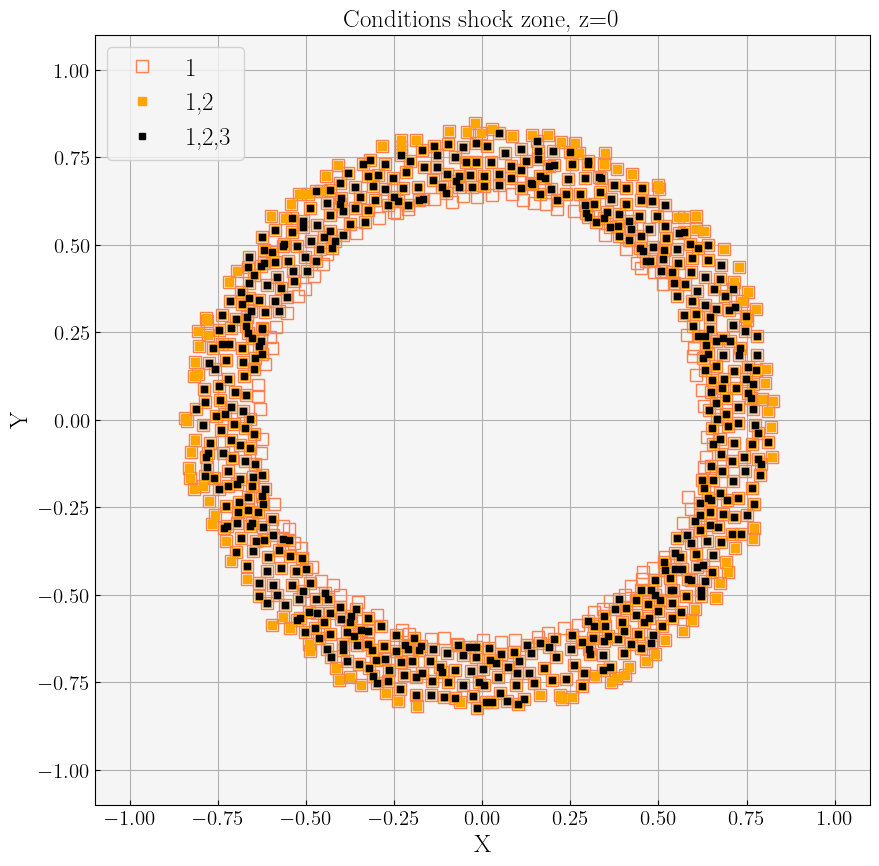

In [15]:
# Plot 3 conditions (cross section)
if(len(X_shock1[np.abs(Z_shock1-z_chosen)<dim_cell_zone1])>1):
    if folder == 'sedov':
        plt.figure(figsize=(10,10))
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
        plt.xlabel('X', fontsize = 18)
        plt.ylabel('Y', fontsize = 18)
    else:
        plt.figure(figsize=(10,6))
        plt.xlabel(r'X[$R_\odot$]', fontsize = 18)
        plt.ylabel(r'Y[$R_\odot$]', fontsize = 18)
    plt.plot(X_shock1[np.abs(Z_shock1-z_chosen)<dim_cell_zone1], Y_shock1[np.abs(Z_shock1-z_chosen)<dim_cell_zone1], 'ks', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
    plt.plot(X_shock2[np.abs(Z_shock2-z_chosen)<dim_cell_zone2], Y_shock2[np.abs(Z_shock2-z_chosen)<dim_cell_zone2], 'ks', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '1,2')
    plt.plot(X_shock[np.abs(Z_shock-z_chosen)<dim_cell_zone], Y_shock[np.abs(Z_shock-z_chosen)<dim_cell_zone], 'ks', markerfacecolor='k', ms=4, markeredgecolor='k', label = '1,2,3')

    plt.legend(loc = 'upper left', fontsize = 18)
    plt.grid()
    plt.title(f'Conditions shock zone, z={z_chosen}', fontsize = 18)

In [16]:
surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post = shock_surface(coordinates, graph, T, P, Den, Elad_divV, ds_all, are_u_shock, indeces_zone)

Plot

In [17]:
surface_x = X[indeces]
surface_y = Y[indeces]
surface_z = Z[indeces]
dim_cell_surf = dim_cell[indeces]

post_x = X[indeces_post]
post_y = Y[indeces_post]
post_z = Z[indeces_post]
dim_cell_post = dim_cell[indeces_post]

pre_x = X[indeces_pre]
pre_y = Y[indeces_pre]
pre_z = Z[indeces_post]
dim_cell_pre = dim_cell[indeces_pre]


In [18]:
zone_cross_x = x_zone[np.abs(z_zone-z_chosen)< dim_cell_zone]
zone_cross_y = y_zone[np.abs(z_zone-z_chosen)< dim_cell_zone]

surface_cross_x = surface_x[np.abs(surface_z-z_chosen)< dim_cell_surf]
surface_cross_y = surface_y[np.abs(surface_z-z_chosen)< dim_cell_surf]

zone_post_x = post_x[np.logical_and(np.abs(surface_z-z_chosen)<dim_cell_surf, np.abs(post_z-z_chosen)<dim_cell_post)] # post_x[np.abs(surface_z-z_chosen)<dim_cell_surf] 
zone_post_y = post_y[np.logical_and(np.abs(surface_z-z_chosen)<dim_cell_surf, np.abs(post_z-z_chosen)<dim_cell_post)] # post_y[np.abs(surface_z-z_chosen)<dim_cell_surf]

zone_pre_x = pre_x[np.logical_and(np.abs(surface_z-z_chosen)<dim_cell_surf, np.abs(pre_z-z_chosen)<dim_cell_pre)] # pre_x[np.abs(surface_z-z_chosen)<dim_cell_surf]
zone_pre_y = pre_y[np.logical_and(np.abs(surface_z-z_chosen)<dim_cell_surf, np.abs(pre_z-z_chosen)<dim_cell_pre)] # pre_y[np.abs(surface_z-z_chosen)<dim_cell_surf]


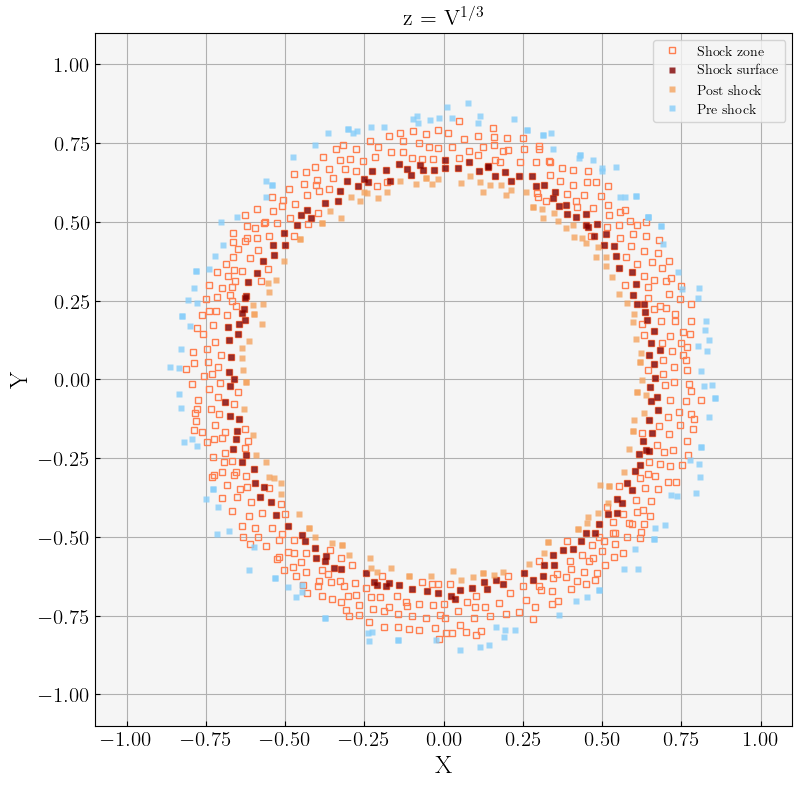

In [19]:
fig, ax = plt.subplots(1,1, figsize = (9,9))
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 4, markeredgecolor='none',  alpha = 0.8, label = 'Shock surface')

ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
ax.legend()
ax.set_title(r'z = V$^{1/3}$', fontsize = 16)
plt.grid()

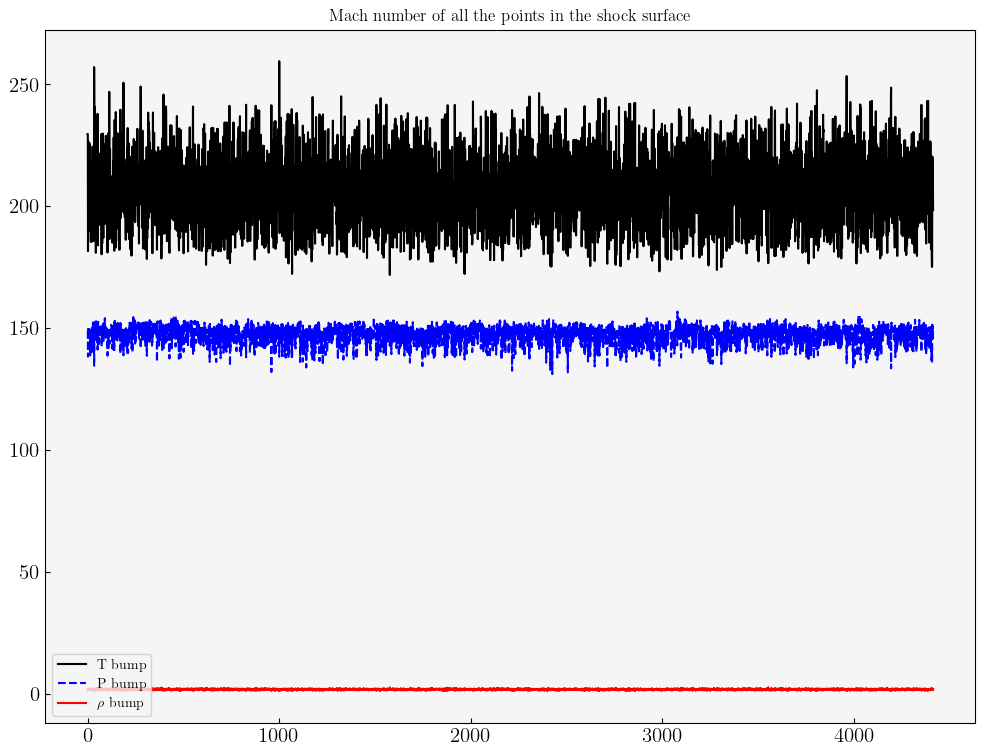

In [20]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot(surface_Tmach, c = 'k', label = 'T bump')
ax.plot(surface_Pmach, c = 'b', linestyle = '--', label = 'P bump')
ax.plot(surface_Denmach, c = 'r',  label = r'$\rho$ bump')
plt.title(f'Mach number of all the points in the shock surface')
plt.legend(loc = 'lower left')